# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import os

#Get the present working directory's path
root = os.getcwd()

#Load the paths for training and testing files
training_file = root + '/traffic-signs-data/train.p'
testing_file = root + '/traffic-signs-data/test.p'

# Load the train and test datasets to their respective variables

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.
import numpy as np

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = (X_train.shape[1],X_train.shape[2])

# TODO: How many unique classes/labels there are in the dataset.
n_classes =  np.unique(y_train).size

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

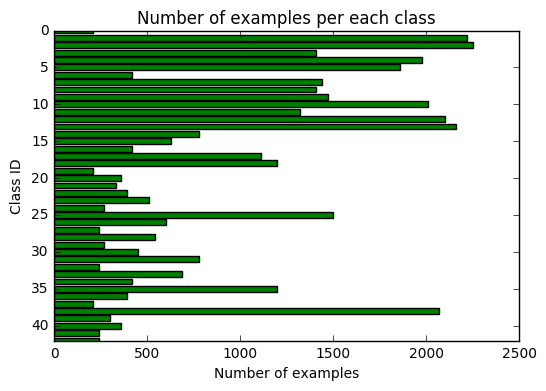

In [3]:
#Data Visualization
#Since we are aware that this is the data from German Traffic Sign Boards dataset, we are aware it is of 43 classes,
#and the individual class images can be looked at from the dataset source itself.
#Instead, here we will try to evaluate and visualize, if the distribution of training examples is as we desire or not.
#We would like to have a distribution where, none of the classes is under-represented.

import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

#Checking the count for each class to ensure that our data is not skewed to one particular class.
num_examples = np.zeros(n_classes)
for class_id in range(0,n_classes):
    num_examples[class_id] = np.where(y_train == class_id)[0].size

#Plotting the examples per class in a bar graph

class_id_for_plotting = np.array(range(0,n_classes))
fig, ax = plt.subplots()
ax.barh(class_id_for_plotting,num_examples,align='center',color='green')
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_ylim(top = 0, bottom = 42)
ax.set_xlabel('Number of examples')
ax.set_ylabel('Class ID')
ax.set_title('Number of examples per each class')

plt.show()


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [4]:
"""In the above visualization we saw that the dataset is skewed, that is few classes have relatively low representation
compared to other classes.
We need to Augment the data to ensure we bring the dataset to some sort of balance.
We will jitter the exisiting data for achieving the same.
There are many methods to jitter the data. Translate by a small amount. Adjust the contrast of the image by a small
amount. Warp/scale the image by a small amount. Rotate the image by a small amount. etc..
The small amount mentioned here is a critical thing to get precisely. CNNs are robust to small jitters in the data, but
beyond this, the jittering could have adverse effects on performance of the ConvNet.
Here, for this project, we will choose rotation of the image (anywhere between 0 and 15 degrees). This is the bound
obtained by the Sermanet-LeCun paper referred above. """


'In the above visualization we saw that the dataset is skewed, that is few classes have relatively low representation\ncompared to other classes.\nWe need to Augment the data to ensure we bring the dataset to some sort of balance.\nWe will jitter the exisiting data for achieving the same.\nThere are many methods to jitter the data. Translate by a small amount. Adjust the contrast of the image by a small\namount. Warp/scale the image by a small amount. Rotate the image by a small amount. etc..\nThe small amount mentioned here is a critical thing to get precisely. CNNs are robust to small jitters in the data, but\nbeyond this, the jittering could have adverse effects on performance of the ConvNet.\nHere, for this project, we will choose rotation of the image (anywhere between 0 and 15 degrees). This is the bound\nobtained by the Sermanet-LeCun paper referred above. '

In [5]:
#Data Augmenting by jittering the image slightly (rotation of the image anywhere between 0 and 15 degrees)
#Code Commented below to prevent any accidental running of the cell, as it takes an hour to run again.
#The augmented dataset is stored as pickle file for future use

# from skimage.transform import rotate

# Min_img_per_class = 750

# #Get which classes have less than 750 images
# for class_id in range(0,n_classes):
#     print('Augmenting class', class_id)
#     if num_examples[class_id] < Min_img_per_class:
#         base_dataset_imgIndex = np.where(y_train == class_id)[0]
#         rndm_img_num = np.random.randint(num_examples[class_id], size = int(Min_img_per_class - num_examples[class_id]))
#         for image_aug_id in range(0, int(Min_img_per_class - num_examples[class_id])):
#             print('image augment count',image_aug_id)
#             image = X_train[base_dataset_imgIndex[rndm_img_num[image_aug_id]]]
#             image_rotate = rotate(image,np.random.rand()*15)
#             X_train = np.concatenate((X_train, np.array([image_rotate])), axis=0)
#             y_train = np.concatenate((y_train,[class_id]))
            

In [6]:
#Store the augmented data for future use
train_augmented = {'features':X_train, 'labels':y_train}
file = "./train_augmented.p"

# Saving the file after augmentation process is run
## with open(file, "wb") as f:
##     pickle.dump(train_augmented, f)

# Loading augmented data from the file for the trials when augmented data is readily used to tune other aspects of the
# ConvNet parameters

with open(file, "rb") as f:
    train_augmented = pickle.load(f)
X_train = train_augmented['features']
y_train = train_augmented['labels']


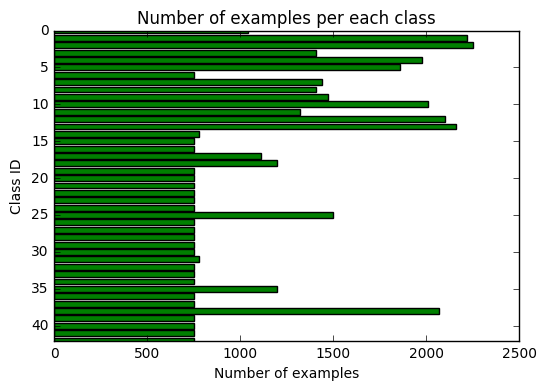

[ 1041.  2220.  2250.  1410.  1980.  1860.   750.  1440.  1410.  1470.
  2010.  1320.  2100.  2160.   780.   750.   750.  1110.  1200.   750.
   750.   750.   750.   750.   750.  1500.   750.   750.   750.   750.
   750.   780.   750.   750.   750.  1200.   750.   750.  2070.   750.
   750.   750.   750.]


In [7]:
"""The preliminary reason for augmenting the dataset was to bring a balance to number of examples among the classes.
Arbitrarily a number = 750 training examples was chosen as minimum for each class.
Any class having less than that, was subjected to jittering process to bring the training examples to 750.
The same is verified and visualized below"""

num_examples_aug = np.zeros(n_classes)
for class_id in range(0,n_classes):
    num_examples_aug[class_id] = np.where(y_train == class_id)[0].size

class_id_for_plotting = np.array(range(0,n_classes))
fig, ax = plt.subplots()
ax.barh(class_id_for_plotting,num_examples_aug,align='center',color='green')
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_ylim(top = 0, bottom = 42)
ax.set_xlabel('Number of examples')
ax.set_ylabel('Class ID')
ax.set_title('Number of examples per each class')

plt.show()
print(num_examples_aug)


In [8]:
#Data Preprocessing

""" Now that we have the augmented data, we get to pre-process the data. From the same Sermanet-LeCun paper, we can 
glean that for this dataset, the color of the image doesn't contribute much to the discriminatory power of the ConvNet
to distinguish one class from another. So we will convert everything to grayscale. and, It is a best practice, for 
training ConvNets that the data be normalized. Hence, we normalize the data after grayscale conversion to a [-1,1]
range."""

#Convert the dataset into grayscale

X_train_grayscale = np.sum(X_train, axis=3, keepdims=True)/3.0
X_test_grayscale = np.sum(X_test, axis =3, keepdims=True)/3.0

# Sanity check for dimensionality
print("RGB dataset's shape", X_train.shape)
print("Grayscale dataset's shape",X_train_grayscale.shape)

X_train = X_train_grayscale
X_test = X_test_grayscale

RGB dataset's shape (48561, 32, 32, 3)
Grayscale dataset's shape (48561, 32, 32, 1)


In [9]:
#Normalize the train and test datasets so as to have a range of [-1,1]
X_train = (X_train - 128.0)/128.0
X_test = (X_test - 128.0)/128.0


In [10]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

X_train, y_train = shuffle(X_train, y_train)
X_train, y_train = shuffle(X_train, y_train)

#Split the train dataset to train and validation datasets
#80% train and 20% validation split
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [11]:
print('Size of Test Data',X_train.shape[0])
print('Size of Validation Data',X_validation.shape[0])

Size of Test Data 38848
Size of Validation Data 9713


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:** From the same Sermanet-LeCun paper, we can glean that for this dataset, the color of the image doesn't contribute much to the discriminatory power of the ConvNet to distinguish one class from another, So I chose to convert the dataset into grayscale (This is also recommended in teh Sermanet-LeCun paper). and, It is a best practice (in general), for training ConvNets that the data be normalized. Hence, I normalized the data after grayscale conversion to a [-1,1] range.

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:** The dataset comes with train and test dataset as all datasets usually do!
I split the train dataset into train and validation sets (80% as train and 20% as validation), as a held out validation dataset away from training can give us indications as to how we can expect our model would perform in the real world. Also, validation dataset gives us valuable information to catch and prevent overfitting in our training model.
With respect to generating additional data (data augmentation), I felt it is necessary in this case. The initial distribution of number of training examples among classes were skewed to some classes. To correct for this, I jittered the data (small random rotations). The post data-augmentation distribution is definitely better than the pre-augmentation distribution (The same can be observed visually in two bar graphs in the above cells).


In [12]:
# Crux of the implementation
# Defining the architecture of the ConvNet

import tensorflow as tf

EPOCHS = 50
BATCH_SIZE = 128

In [13]:
from tensorflow.contrib.layers import flatten

def LeNet(x,keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    #Activation.
    conv1 = tf.nn.relu(conv1)

    #Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    #Dropout after Conv1 layer
    conv1 = tf.nn.dropout(conv1, keep_prob)

    #Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    #Activation.
    conv2 = tf.nn.relu(conv2)

    #Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Dropout after conv2
    #conv2 = tf.nn.dropout(conv2, keep_prob)

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:** The final architecture is the same as LeNet (but, with a Dropout layer between the convolution1 layer and convolution2 layer - for preventing overfitting). LeNet does exceedingly well on the MNIST dataset (10 classes). This Traffic signs datase is of 43 classes. I felt that LeNet is big enough in terms of its number of parameters to work well for 43 classes. If the dataset had more classes in terms of 100s, then we would have required a deeper architecture.  

* Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
* Layer 2: Max Pooling. Input = 28x28x6. Output = 14x14x6.
* Layer 3: Dropout (with keep probability of 0.5 - during training, and 1.0 - during evaluation)
* Layer 4: Convolutional. Input = 14x14x6. Output = 10x10x16.
* Layer 4: Max Pooling. Input = 10x10x16. Output = 5x5x16. (Output flattened to 400 for connecting to FC layers)
* Layer 5: Fully Connected. Input = 400. Output = 120.
* Layer 6: Fully Connected. Input = 120. Output = 84.
* Layer 7: Fully Connected. Input = 84. Output = 43.


In [14]:
# Some placeholders for running the model

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

In [15]:
#Learning rate 
#Default rate of 0.001 quite prevalent in literature is used,and the same works well. 
rate = 0.001

logits = LeNet(x,keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [16]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob : 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [17]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.749

EPOCH 2 ...
Validation Accuracy = 0.874

EPOCH 3 ...
Validation Accuracy = 0.916

EPOCH 4 ...
Validation Accuracy = 0.928

EPOCH 5 ...
Validation Accuracy = 0.948

EPOCH 6 ...
Validation Accuracy = 0.961

EPOCH 7 ...
Validation Accuracy = 0.963

EPOCH 8 ...
Validation Accuracy = 0.972

EPOCH 9 ...
Validation Accuracy = 0.969

EPOCH 10 ...
Validation Accuracy = 0.977

EPOCH 11 ...
Validation Accuracy = 0.975

EPOCH 12 ...
Validation Accuracy = 0.982

EPOCH 13 ...
Validation Accuracy = 0.974

EPOCH 14 ...
Validation Accuracy = 0.984

EPOCH 15 ...
Validation Accuracy = 0.984

EPOCH 16 ...
Validation Accuracy = 0.982

EPOCH 17 ...
Validation Accuracy = 0.987

EPOCH 18 ...
Validation Accuracy = 0.987

EPOCH 19 ...
Validation Accuracy = 0.988

EPOCH 20 ...
Validation Accuracy = 0.982

EPOCH 21 ...
Validation Accuracy = 0.987

EPOCH 22 ...
Validation Accuracy = 0.989

EPOCH 23 ...
Validation Accuracy = 0.988

EPOCH 24 ...
Validation Accura

In [18]:
## Testing!!!!!!

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.921


### Test Accuracy of 92.1%

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

* Adam Optimizer and a batch size of 128 is used. This batch most prevalent in literature, and the optimizer is suggested in modern papers over others.

* EPOCH of 50 is used. But, after 25 or so, not much progress is made in terms of improvement of accuracy in classification. 

* mu =0 and sigma = 0.1 is used by default for initializing the weights in the network (again, commonly done in the literature) and all biases are set to zero.
   

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**
1) Initially, the base dataset without augmentation and base network without dropout was used. This yielded a validation accuracy of 96% percent or so. But, since the network didn't have a dropout layer for regularization, I didn't pay much heed to the result( as there is plenty of a chance to overfit to the training data). But, this baseline accuracy corroborated my decision to stick with base LeNet model for this task. so, I went on to the next steps!

2) Next, jumping into the training process full-on, I augmented the dataset and normalized it of-course! Added a dropout layer between the convolution1 and convolution2 layers. With this, I got around 98% accuracy on validation dataset.

3) Next, the images were converted to grayscale before normalizing and normalizing was carried on onto the grayscale converted dataset. With this, I got around 99% accuracy on validation dataset.

4) With this trained model, I got an accuracy of 92% on the test dataset. To be frank I expected the accuracy to be around 94-95 or so. I think, adding another dropout layer and playing around with the dropout rates might get this to the 94-95% figure. But, I think increasing the number is not the point of this assignment, as we can unleash GoogLeNet on this to get 99% accuracy, but instead is to understand the effects that all the parameters play in tuning the network. I have gotten a lot of exposure on how, right from distribution of the dataset to regularization via dropout (and everthing in between) can be used to better the performance of the network.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

./testImageFromNet/testimage1.png
./testImageFromNet/testimage2.png
./testImageFromNet/testimage3.png
./testImageFromNet/testimage4.png
./testImageFromNet/testimage5.png
./testImageFromNet/testimage6.png
./testImageFromNet/testimage7.png
./testImageFromNet/testimage8.png
Shape of Test Images (RGB) (8, 32, 32, 3)
Shape of Test Image (Grayscale) (8, 32, 32, 1)


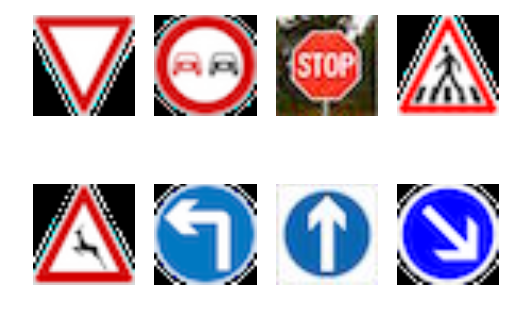

In [19]:
#The test images gathered from internet

import matplotlib.image as mpimg
import glob
import cv2

fig, axs = plt.subplots(2,4)
axs = axs.ravel()

index = 0
testImages = []
for filename in glob.glob('./testImageFromNet/*.png'):
    print(filename)
    image = cv2.imread(filename)
    axs[index].axis('off')
    axs[index].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    testImages.append(image)
    index = index + 1

testImages = np.asarray(testImages) 
    
#Grayscale    
testImages_gray = np.sum(np.asarray(testImages), axis=3, keepdims=True)/3.0
#Normalization
testImages_norm = (testImages_gray - 128.0)/128.0

#Sanity Check
print('Shape of Test Images (RGB)',testImages.shape)
print('Shape of Test Image (Grayscale)',testImages_gray.shape)


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**
I chose quite iconic, and high clarity images to test the network. The network should not have much problems with these images. If the images come with reduced lumination,or some sort of occlusion, or even a difficult orientation, these things could cause problems in detection accuracy.

In [20]:
### Running the predictions on the above collected test images.
### Feel free to use as many code cells as needed.
testLabels = [13,9,14,27,31,34,35,38]

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    accuracy_testImages = evaluate(testImages_norm, testLabels)
    print("TestImages Accuracy = {:.3f}".format(accuracy_testImages))

TestImages Accuracy = 0.875


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**
Yes. The model performs well on the test images.
As mentioned above, since the images are sort of iconic and of high clarity without much disturbences that could lead the network astray, the network performs well on each of them. 
I collected the class id from the csv file and resused the evaluate code from above to calculate the accuracy.

In [27]:
### Visualizing the softmax probabilities here.

softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k=3)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    testImages_top_k = sess.run(top_k, feed_dict={x: testImages_norm, keep_prob: 1.0})
    print(testImages_top_k)

TopKV2(values=array([[  1.00000000e+00,   8.32427118e-14,   2.73824948e-18],
       [  8.96483064e-01,   7.56275281e-02,   2.22658291e-02],
       [  9.91222024e-01,   8.18675384e-03,   5.71677985e-04],
       [  9.38329577e-01,   3.76494788e-02,   7.15201860e-03],
       [  1.00000000e+00,   1.06005693e-08,   5.17032181e-11],
       [  9.99935985e-01,   6.40209837e-05,   1.65033303e-08],
       [  1.00000000e+00,   9.69153360e-13,   5.37421970e-16],
       [  9.99785006e-01,   2.14935470e-04,   1.27368665e-07]], dtype=float32), indices=array([[13, 35, 36],
       [ 9, 28, 12],
       [14, 17, 10],
       [18, 11, 27],
       [31, 23, 21],
       [34, 38, 16],
       [35, 13, 33],
       [38, 23, 31]], dtype=int32))


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**
The softmax probabilites are visualized using the tensorflow function indicated. This results corroborates well with the accuracy figures seen above. 

* All the examples were classified correctly except for the 4th one (Pedestrian Crossing - Class ID 27). Instead Class ID 27 came in third. Class ID 18 and Class ID 11 came in first and second. Similarity of the sign boards might be causing this! Also, this could well be the defiency in the network's accuracy showing up (Test accuracy is at 92.1%). But, Class ID is atleast in Top-3, which is a consolation prize!

* The softmax probabilite reveal much more information than plain accuracy values, as you can see if your network is adept at identifying a class, or it just about makes it to classify it correctly by comparing the logits of the top class versus the following ones. This is very valuable in analyzing where can we improve the network further! :)

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.